In [1]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import sys

import torch
from torch import nn
from torch import optim
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform
import sys
import itertools

from nf.conditional_prior import ConditionalDiagonalNormal
from nf.nets import MLP

from nf.flows import NormalizingFlow, NormalizingFlowModel, Invertible1x1Conv, ActNorm
from nf.spline_flows import NSF_CL

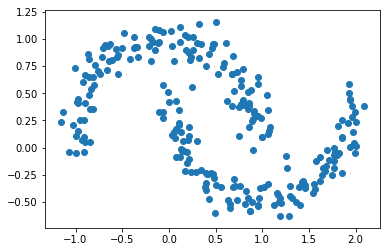

In [2]:
x, _ = datasets.make_moons(256, noise=.1)
plt.scatter(x[:, 0], x[:, 1]);

num_layers = 5
prior = TransformedDistribution(Uniform(torch.zeros(2), torch.ones(2)), SigmoidTransform().inv)

In [3]:
dim = x.shape[-1]

nfs_flow = NSF_CL
flows = [nfs_flow(dim=dim, K=8, B=3, hidden_dim=128) for _ in range(3)]
convs = [Invertible1x1Conv(dim=dim) for _ in flows]
norms = [ActNorm(dim=dim) for _ in flows]
flows = list(itertools.chain(*zip(norms, convs, flows)))

# construct the model
flow = NormalizingFlowModel(prior, flows)

/Users/ioanaciuca/anaconda3/envs/moreDL/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/RangeFactories.cpp:23.)


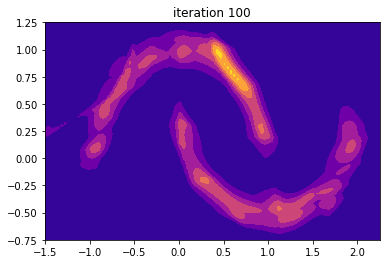

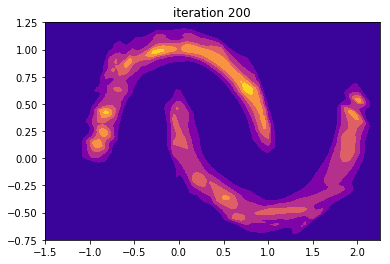

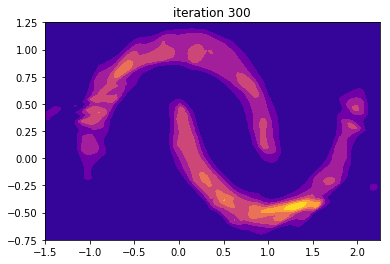

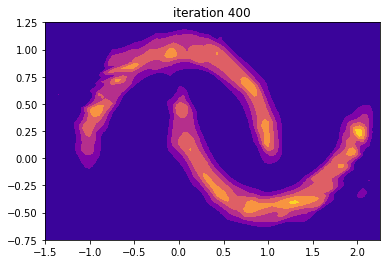

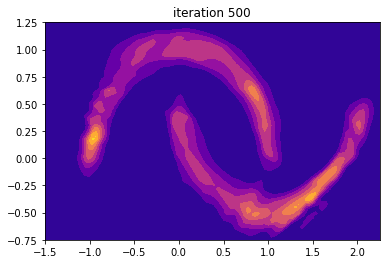

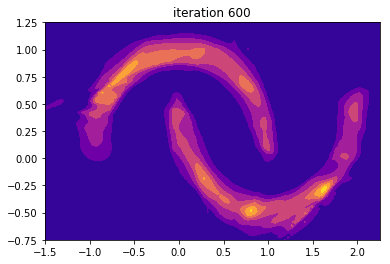

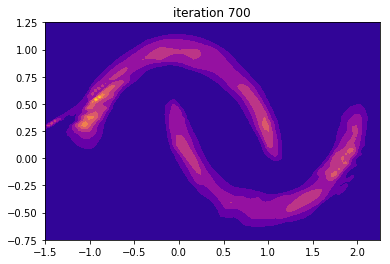

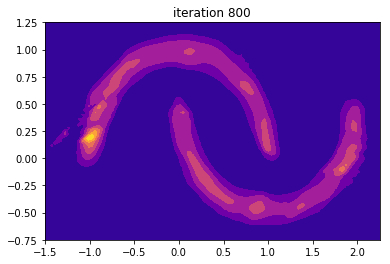

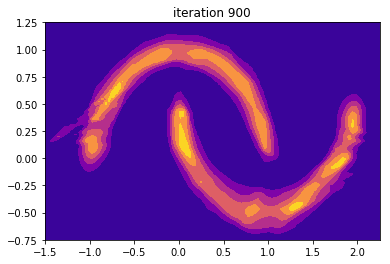

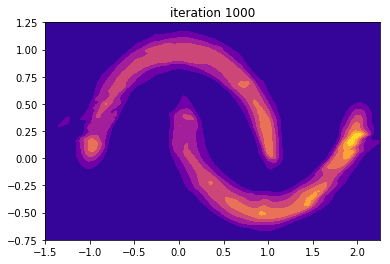

In [4]:
optimizer = optim.Adam(flow.parameters())

num_iter = 1000
for i in range(num_iter):
    x, y = datasets.make_moons(128, noise=.1)
    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
    optimizer.zero_grad()
    zs, prior_logprob, log_det = flow(x, context=None)
    logprob = prior_logprob + log_det
    loss = -torch.mean(logprob) # NLL
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 100 == 0:
        fig = plt.subplots()
        xline = torch.linspace(-1.5, 2.25)
        yline = torch.linspace(-.75, 1.25)
        xgrid, ygrid = torch.meshgrid(xline, yline)
        xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

        with torch.no_grad():
            z, prior_logprob, log_det = flow(xyinput, context=None)
            logprob = (prior_logprob + log_det).exp().reshape(100, 100)

        plt.contourf(xgrid.numpy(), ygrid.numpy(), logprob.numpy(), cmap='plasma')
        plt.title('iteration {}'.format(i + 1))
        plt.show()
